In [86]:
import pandas as pd
import numpy as np
from dateutil import relativedelta
pd.options.display.max_rows = 100
from datetime import datetime
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [87]:
from os import pardir, path
import sys
mod_path = path.abspath(path.join(pardir))

print(mod_path)

if mod_path not in sys.path:
    sys.path.append(mod_path)

print(sys.path)
from data_extract import client, fin, company , companyfinancials_list, pnl, bs, cf, profile, prices, fx, mrktcap, prices_n_fin,  MONGO_FIN
from mypackage import calperiod

/Users/karimkhalil/Coding/development/fin
['/Users/karimkhalil/Coding/development/fin/notebooks', '/Users/karimkhalil/Coding/development/fin/conda_env/lib/python39.zip', '/Users/karimkhalil/Coding/development/fin/conda_env/lib/python3.9', '/Users/karimkhalil/Coding/development/fin/conda_env/lib/python3.9/lib-dynload', '', '/Users/karimkhalil/Coding/development/fin/conda_env/lib/python3.9/site-packages', '/Users/karimkhalil/Coding/development/fin']


In [88]:
db = MONGO_FIN()

In [89]:
df1 = pd.read_csv("../data/data_prefeatures.csv")
df1['marketCap_log'] = np.log(df1['usd_marketCap'])

# market returns

df_mrkt1 = df1[['symbol', 'industry-category' , 'companyName', 'cal_yearperiod', 'year','datetime', 'usd_adjClose', 'usd_marketCap' , 'marketCap_log']]
df_mrkt1.head(5)

symbol         industry-category                    companyName  \
0   OSUR            pharma-medical     OraSure Technologies, Inc.   
1    CVM            pharma-medical            CEL-SCI Corporation   
2    UNF         business_services           UniFirst Corporation   
3      J  engineering_construction  Jacobs Engineering Group Inc.   
4   MSFT             tech-software          Microsoft Corporation   

  cal_yearperiod  year    datetime  usd_adjClose  usd_marketCap  marketCap_log  
0         1988Q4  1988  1988-12-31      5.562700   2.424400e+08      19.306265  
1         1988Q4  1988  1988-12-31   1562.500000   1.562500e+07      16.564383  
2         1988Q4  1988  1988-11-30      5.109196   1.237005e+08      18.633374  
3         1989Q4  1989  1989-12-31      1.627321   1.494300e+08      18.822339  
4         1989Q4  1989  1989-12-31      0.379752   5.127600e+09      22.357904

In [90]:
## check periods per company
df_companyperiod = df1.groupby(['symbol' , 'year'])['key'].count().reset_index()
df_companyperiod.groupby('key')['symbol'].count().reset_index()

key  symbol
0    1   38746
1    2   10809
2    3   10583
3    4  129798

In [91]:
df_companyperiod2 = df1.groupby(['symbol' , 'cal_yearperiod' ])['key'].count().reset_index()
df_companyperiod2.groupby('key')['symbol'].count().reset_index()

key  symbol
0    1  611305

In [92]:
# number of companies per period
df_plot = df1.groupby(['cal_yearperiod']).agg({'usd_marketCap': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='symbol' , 
    labels={
        "symbol": "Number of companies",
        "cal_yearperiod" : "Period"
    },
    width=1700)
fig.update_layout(
    title={
        "text" : "Number of companies by period",
        'x':0.5},
    xaxis={"tickfont":{"size": 8} })
fig.show()

In [93]:
# df1.loc[df1['symbol']=='GMGI', ['cal_yearperiod' , 'datetime' , 'usd_marketCap', 'usd_adjClose']]

In [94]:
# number of companies per period
df_plot = df1.groupby(['cal_yearperiod', "industry-category"]).agg({ 'usd_marketCap': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='symbol' , 
    labels={
        "symbol": "Number of companies",
        "cal_yearperiod" : "Period"
    },
    color='industry-category')
fig.update_layout(
    title={
        "text" : "Number of companies by period per sector",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })
fig.show()

In [95]:
df_plot = df1.groupby(['cal_yearperiod', "industry-category"]).agg({ 'usd_marketCap': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='usd_marketCap' , 
    labels={
        "usd_marketCap": "Market Capitalization",
        "cal_yearperiod" : "Period"
    },
    color='industry-category')
fig.update_layout(
    title={
        "text" : "Market Capitalization by period per sector",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })
fig.show()

In [96]:
df_plot = df1.groupby(['cal_yearperiod', "industry-category"]).agg({ 'marketCap_log': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='marketCap_log' , 
    labels={
        "marketCap_log": "Log Market Capitalization",
        "cal_yearperiod" : "Period"
    },
    color='industry-category')


fig.update_layout(
    title={
        "text" : "Log of Market Capitalization by period per sector",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })
fig.show()

In [97]:
# remove outliers on standard deviation of market cap

#############################################
n = 11 ## number of observations to remove
#############################################
df_mrkt1_stat = df_mrkt1.groupby('symbol').agg(Std_mrktcap=('usd_marketCap', 'std'))
df_mrkt1_stat.reset_index(inplace=True)
df_mrkt1_stat = df_mrkt1_stat.loc[df_mrkt1_stat['Std_mrktcap'].notna()]

n_obs = df_mrkt1_stat.shape[0]

df_mrkt1_stat['rank'] = df_mrkt1_stat['Std_mrktcap'].rank()
df_mrkt1_stat['rank_pct'] = df_mrkt1_stat['Std_mrktcap'].rank(pct=True)

outlier_mrktcap= df_mrkt1_stat.loc[df_mrkt1_stat['rank'] <= n_obs-n , 'symbol'].values.tolist()


## filtering out most varying 11 companies market cap
df2 = df1[df1['symbol'].isin(outlier_mrktcap)]

df_mrkt2 = df_mrkt1[df_mrkt1['symbol'].isin(outlier_mrktcap)]



In [98]:
# export data after removing 11 most noisy companies
df2.to_csv('../data/data_vf.csv')

In [99]:
df_plot = df2.groupby(['cal_yearperiod', "industry-category"]).agg({ 'usd_marketCap': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='usd_marketCap' , 
    labels={
        "usd_marketCap": "Market Capitalization",
        "cal_yearperiod" : "Period"
    },
    color='industry-category')
fig.update_layout(
    title={
        "text" : "Market Capitalization by Period (after removing outliers)",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })
fig.show()


array([[<AxesSubplot:title={'center':'Std_mrktcap'}>]], dtype=object)

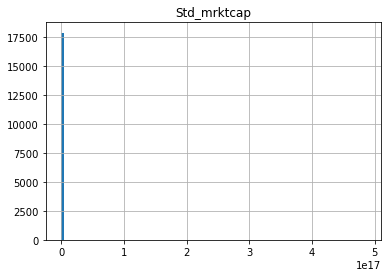

In [100]:
df_mrkt1_stat[df_mrkt1_stat['Std_mrktcap']>0].hist(column='Std_mrktcap', bins=100)

# Market Index

In [101]:
df_mrkt_test = df1.loc[df1['cal_yearperiod'].isin(['1989Q2', '1989Q1' , '1988Q4']), ['symbol','cal_yearperiod', 'year','datetime', 'usd_adjClose', 'usd_marketCap']]
# df_mrkt_test.to_excel('../data.xlsx')

def mrkt_index(df, period_column:str , symbol_col:str , weighted_column:str):
    d = {}
    periods = np.sort(df[period_column].unique())
    for i in periods:
        t = periods[int(np.where(periods==i)[0])]
        t_prev = periods[int(np.where(periods==i)[0])-1]
        co = set(df.loc[df[period_column]== t , symbol_col])
        co_count = len(co)
        all_mrktcap = df.loc[(df[period_column] == t), weighted_column].sum()
        all_mrktcap_prev = df.loc[(df[period_column] == t_prev), weighted_column].sum()
        # print(t , t_prev)
        if t == periods[0]:
            d[i] = {
            'mrktcap' : all_mrktcap,
            'mrktcap_prev': 'na',
            'company_count' : co_count,
            'company_count_prev' : 'na',
            'div' : all_mrktcap/1000,
            'div_prev': 'na',
            'index' : all_mrktcap / (all_mrktcap/1000),
            'index_prev': 'na'}
        else:
            co = set(df.loc[df[period_column]== t , symbol_col])
            co_prev = set(df.loc[df[period_column]== t_prev , symbol_col])
            co_count_prev = d[t_prev]['company_count']
            add = co.difference(co_prev)
            add_mrktcap = df.loc[(df[period_column] == t) & (df[symbol_col].isin(add)), weighted_column].sum()
            delete = co_prev.difference(co)
            delete_mrktcap =  - df.loc[(df[period_column] == t_prev) & (df[symbol_col].isin(delete)), weighted_column].sum()
            inter = co.intersection(co_prev)
            inter_mrktcap = df.loc[(df[period_column] == t) & (df[symbol_col].isin(inter)), weighted_column].sum()
            inter_mrktcap_prev = df.loc[(df[period_column] == t_prev) & (df_mrkt_test[symbol_col].isin(inter)), weighted_column].sum()
            div_prev = d[t_prev]['div']
            index_prev = d[t_prev]['index']
            delta_recon = (add_mrktcap+delete_mrktcap)/all_mrktcap_prev

            d[i] = {
                'mrktcap' : all_mrktcap,
                'mrktcap_prev': all_mrktcap_prev,
                'company_count' : co_count,
                'company_count_prev' : co_count_prev,
                'div': (1+delta_recon)*div_prev,
                'div_prev': div_prev,
                'index': all_mrktcap/((1+delta_recon)*div_prev),
                'index_prev': index_prev}
        
    l = []
    for i in d:
        d2 = {}
        d2['cal_yearperiod'] = i
        d2.update(d[i])
        l.append(d2)
    
    df2 = pd.DataFrame.from_records(l)
            
    return d , df2

dict_index_test , df_index_test = mrkt_index(df_mrkt_test, 'cal_yearperiod' , 'symbol' , 'usd_marketCap')

In [102]:
# create market Index

## market cap weighted index
df_mrkt_index2 = mrkt_index(df_mrkt2, 'cal_yearperiod' , 'symbol' , 'usd_marketCap')[1]
df_mrkt2 = df_mrkt2.merge(df_mrkt_index2[['cal_yearperiod', 'div']], how = 'inner' , on = 'cal_yearperiod')



In [103]:
df_mrkt2.columns

Index(['symbol', 'industry-category', 'companyName', 'cal_yearperiod', 'year',
       'datetime', 'usd_adjClose', 'usd_marketCap', 'marketCap_log', 'div'],
      dtype='object')

In [104]:
## log of market cap weighted index
cols_mrkt3 = [i for i in df_mrkt2.columns if i != 'div' and i != 'index']

df_mrkt_index3 = mrkt_index(df_mrkt2[cols_mrkt3], 'cal_yearperiod' , 'symbol' , 'marketCap_log')[1]


In [105]:
df_mrkt3 = df_mrkt2[cols_mrkt3].merge(df_mrkt_index3[['cal_yearperiod', 'div']], how = 'inner' , on = 'cal_yearperiod')

In [106]:
df_plot = df_mrkt_index2

fig = px.line(
    df_plot, 
    x='cal_yearperiod', y='index' , 
    labels={
        "index": "Index Level",
        "cal_yearperiod" : "Period"
    })

fig.update_layout(
    title={
        "text" : "Market Index by Period",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })
fig.show()

In [107]:
df_plot = df_mrkt_index3

fig = px.line(
    df_plot, 
    x='cal_yearperiod', y='index' , 
    labels={
        "index": "Index Level",
        "cal_yearperiod" : "Period"
    })
fig.update_layout(
    title={
        "text" : "Market Index by Period (log marketcap)",
        'x':0.5},
    width=1000,
    xaxis={"tickfont":{"size": 8} })
fig.show()

In [108]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_mrkt_index2['cal_yearperiod'], y=df_mrkt_index2['index'], name='Index Value (marketCap)'), secondary_y=False)
fig.add_trace(go.Scatter(x=df_mrkt_index3['cal_yearperiod'] , y=df_mrkt_index3['index'], name='Index Value (log of marketCap)'), secondary_y=True)
fig.update_layout(title={
    'text': "Market Index by Period (Market cap vs log of Market cap)", 
    'x':0.5})
fig.show()

In [109]:
df_mrkt2['index'] = df_mrkt2['usd_marketCap'] / df_mrkt2['div']
df_mrkt_index2_check = df_mrkt2.groupby('cal_yearperiod')['index'].sum()


df_plot = df_mrkt2.groupby(['cal_yearperiod', "industry-category"]).agg({ 'index': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='index' , 
    labels={
        "index": "Index Level",
        "cal_yearperiod" : "Period"
    },
    color='industry-category')
    
fig.update_layout(
    title={
        "text" : "Market Index by Period and Industry",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })

fig.add_scatter(x = df_mrkt_index2['cal_yearperiod'] , y= df_mrkt_index2['index'] , line_color = 'purple')

fig.show()

In [110]:
df_mrkt3['index'] = df_mrkt3['marketCap_log'] / df_mrkt3['div']
df_mrkt_index3_check = df_mrkt3.groupby('cal_yearperiod')['index'].sum()


df_plot = df_mrkt3.groupby(['cal_yearperiod', "industry-category"]).agg({ 'index': "sum" , "symbol": 'count'}).reset_index()

fig = px.bar(
    df_plot, 
    x='cal_yearperiod', y='index' , 
    labels={
        "index": "Index Level",
        "cal_yearperiod" : "Period"
    },
    color='industry-category')
    
fig.update_layout(
    title={
        "text" : "Market Index by Period and Industry (log market cap)",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })

fig.update_yaxes(range=[1000,1150])

fig.add_scatter(x = df_mrkt_index3['cal_yearperiod'] , y= df_mrkt_index3['index'] , line_color = 'purple')

fig.show()

In [111]:
df_plot_pharma = df_mrkt2[df_mrkt2["industry-category"]=='pharma-medical']

fig = px.bar(
    df_plot_pharma, 
    x='cal_yearperiod', y='index' , 
    labels={
        "index": "Index Level",
        "cal_yearperiod" : "Period"
    },
    color='companyName')
    
fig.update_layout(
    title={
        "text" : "Market Index by Period Pharma",
        'x':0.5},
    width=1700,
    xaxis={"tickfont":{"size": 8} })

In [112]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

df_respire = df_mrkt2[df_mrkt2['companyName'] == 'RespireRx Pharmaceuticals Inc.'][['cal_yearperiod' ,'index' , 'usd_marketCap']]

fig.add_trace(go.Scatter(x=df_respire['cal_yearperiod'], y=df_respire['index'], name='Index Value'), secondary_y=False)
fig.add_trace(go.Scatter(x=df_respire['cal_yearperiod'] , y=df_respire['usd_marketCap'], name='Market Cap'), secondary_y=True)

fig.update_layout(title={
    'text': "RespireRx Pharmaceuticals Inc.", 
    'x':0.5})

fig.show()

In [113]:
# # Market portfolio: (not complete)

# # df_mrkt_port_test = df_mrkt2.loc[df_mrkt2['cal_yearperiod'].isin(['1989Q1' , '1988Q4', '1989Q2']), ['symbol', 'industry-category' , 'cal_yearperiod' , 'year' , 'datetime', 'usd_adjClose', 'usd_marketCap']]
# df_mrkt_port_test = df_mrkt2.loc[df_mrkt2['cal_yearperiod'].isin(['1988Q4','1989Q1', '1989Q2']), ['symbol', 'industry-category' , 'cal_yearperiod' , 'year' , 'datetime', 'usd_adjClose', 'usd_marketCap']]
# period_column = 'cal_yearperiod' 
# symbol_col = 'symbol' 
# weighted_column = 'usd_marketCap'

# def mrkt_port(df, period_column:str , datetime_column:str , symbol_col:str , weighted_column:str):
#     d = {}
#     periods = np.sort(df[period_column].unique())
#     df_returns = returns(df,1, symbol_col , datetime_column , weighted_column)
#     df_returns['key'] = df_returns[symbol_col]+"."+df_returns[period_column]

#     # return df
#     for i in periods:
#         t = periods[int(np.where(periods==i)[0])]
#         co = set(df.loc[df[period_column]== t , symbol_col])
#         if i != periods[-1]:
#             t_after = periods[int(np.where(periods==i)[0])+1]
#             co_after = set(df.loc[df[period_column]== t_after , symbol_col])
#             co_inter = co.intersection(co_after)
#             df_mrktcap_after = df.loc[(df[period_column] == t_after), weighted_column].sum()
#             df_mrktcap_inter = df.loc[(df[symbol_col].isin(co_inter)) & (df[period_column] == t_after), [symbol_col, weighted_column]]
#             df_mrktcap_share = share(df_mrktcap_inter, weighted_column)
#             d[i] = {'t+1': t_after , 'df_share': df_mrktcap_share}
    
#     l = []
#     for i in d:
#         df2 = d[i]['df_share']
#         df2[period_column] = i
#         df2[period_column+'_t+1'] = d[i]['t+1']
#         l.append(df2)

#     df_shares = pd.concat(l)
#     df_shares['key'] = df_shares[symbol_col]+"."+df_shares[period_column+'_t+1']

#     df_shares = df_shares.merge(df_returns[['key', weighted_column+'_t-1_returns']], how = 'inner' , on = 'key')

#     return df_shares, df_returns



# df_portshares, df_portreturns = mrkt_port(df_mrkt_port_test, 'cal_yearperiod' ,'datetime',  'symbol' , 'usd_marketCap')

In [ ]:
df_idx_q = pd.read_csv('../data/df_idx_q.csv')[['symbol' , 'date' , 'adjClose']]
df_idx_all = pd.read_csv('../data/df_index_all.csv')
df_idx_q.columns

In [ ]:
df_idx_q = df_idx_q.merge(df_idx_all[['symbol' , 'name']], how='inner' , on='symbol')

In [ ]:
df_idx_q = calperiod(df_idx_q, 'date')
df_idx_q.columns

In [ ]:
df_idx_q.loc[df_idx_q.name.str.startswith('S&P'), ['symbol', 'name']].drop_duplicates(keep='first')

In [ ]:
df_snp = df_idx_q.loc[df_idx_q.symbol == 'GSPC']

In [ ]:
df_mrkt_index3['year'] = df_mrkt_index3.cal_yearperiod.apply(lambda x: x[:4])

In [ ]:
df_mrkt_index3.head(5)

In [ ]:
df_snp

In [ ]:

df_snp.drop_duplicates(subset=['cal_yearperiod'] , keep='last', inplace=True)
df_snp.sort_values(by=['cal_yearperiod'], inplace=True)


# df_mrkt_index3.sort_values(subset=['cal_yearperiod'], inplace=True)

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=df_snp['cal_yearperiod'], y=df_snp['adjClose'], name='S&P 500'), secondary_y=False)
fig.add_trace(go.Scatter(x=df_mrkt_index3['cal_yearperiod'] , y=df_mrkt_index3['index'], name='Index Value (log of marketCap)'), secondary_y=True)

fig.update_layout(
    title={
    'text': "Market Index by Period (All tickers vs S&P 500)", 
    'x':0.5},
    width=1000,
    xaxis={"tickfont":{"size": 8} , "title":{"text": "Period"} },
    yaxis={"tickfont":{"size": 8} , "title":{"text": "Index Value"} })

fig.show()

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

df_snp_year = df_snp.drop_duplicates(subset=['year'] , keep='last')
df_mrkt_index3_year = df_mrkt_index3.drop_duplicates(subset=['year'] , keep='last')


fig.add_trace(go.Scatter(x=df_snp_year['year'], y=df_snp_year['adjClose'], name='S&P 500'), secondary_y=False)
fig.add_trace(go.Scatter(x=df_mrkt_index3_year['year'] , y=df_mrkt_index3_year['index'], name='All Tickers'), secondary_y=True)

fig.update_layout(
    title={
    'text': "Market Index by Period (All tickers vs S&P 500)", 
    'x':0.5},
    width=1000,
    xaxis={"tickfont":{"size": 12} , "title":{"text": "Year"} },
    yaxis={"tickfont":{"size": 12} , "title":{"text": "Index Value"} })

fig.show()

In [ ]:
len(df1.currency.unique())

In [ ]:
len(df1.country.unique())

In [ ]:
len(df1.symbol.unique())